### Introduction: This is the Jupyter notebook to do the flowing things:

1. Read GoF files to calculate p-value
2. Use GoF to show F-test results

env:bbVV


In [3]:
from typing import List
import uproot
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib.ticker as mticker
import os

plt.style.use(hep.style.CMS)
hep.style.use("CMS")
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 20})


In [4]:
MAIN_DIR = "./plots"

plot_dir = f"{MAIN_DIR}/GoF_combined/18Apr25"
_ = os.system(f"mkdir -p {plot_dir}")

In [5]:
def p_value(data_ts: float, toy_ts: List[float]):
    return np.mean(toy_ts >= data_ts)


def F_statistic(
    ts_low: List[float],
    ts_high: List[float],
    ord_low: int,
    ord_high: int,
    num_bins: int = 20*6 ,# we have 20 bins per region, and 6 regions in total
    dim: int = 2, # number of polynomials to test
):
    numerator = (ts_low - ts_high) / (ord_high - ord_low)
    denominator = ts_high / (num_bins - (ord_high + dim))

    return numerator / denominator

### Quickly test all nTF p-value, according to the output, we prefer to further test (3,6) as final choice

In [6]:
local_cards_dir = "../cards/combined_1lep_0lep/"

file_data = uproot.concatenate(
            f"{local_cards_dir}/higgsCombineData.GoodnessOfFit.mH125.root" # the GoF value for data
        )
data_ts = file_data["limit"][0]
file_toys = uproot.concatenate(
            f"{local_cards_dir}/higgsCombineToys.GoodnessOfFit.mH125.4*.root" # this will automatically collect all the GoF files for multiple toys root file, with seed 4*
        )
toys_ts = np.array(file_toys["limit"])

In [7]:
print(f"GoF for data is: {data_ts}")

GoF for data is: 99.66697955131531


### define plot function

In [8]:
from scipy import stats

def plot_tests(
    data_ts: float,
    toy_ts: np.ndarray,
    name: str,
    title: str = None,
    bins: int = 15,
    fit: str = None,
    fdof2: int = None,
    order_value: str = None
):
    # plot_max = max(np.max(toy_ts), data_ts) #not enough
    # plot_max = 100
    plot_max = 20 if fit != "chi2" else 200
    # plot_min = min(np.min(toy_ts), data_ts, 0)
    plot_min = 40
    pval = p_value(data_ts, toy_ts)

    plt.figure(figsize=(12, 8))
    h = plt.hist(
        toy_ts,
        np.linspace(plot_min, plot_max, bins + 1),
        color="#8C8C8C",
        histtype="step",
        label=f"{len(toy_ts)} Toys",
    )
    plt.axvline(data_ts, color="#FF502E", linestyle=":", label=rf"Data ($p$-value = {pval:.2f})")

    if fit is not None:
        x = np.linspace(plot_min + 0.01, plot_max, 100)

        if fit == "chi2":
            res = stats.fit(stats.chi2, toy_ts, [(0, 200)])
            pdf = stats.chi2.pdf(x, res.params.df)
            label = rf"$\chi^2_{{DoF = {res.params.df:.2f}}}$ Fit"
        elif fit == "f":
            pdf = stats.f.pdf(x, 1, fdof2)
            label = rf"$F-dist_{{DoF = (1, {fdof2})}}$"
        else:
            raise ValueError("Invalid fit")

        plt.plot(
            x,
            pdf * (np.max(h[0]) / np.max(pdf)),
            color="#1f78b4",
            linestyle="--",
            # alpha=0.6,
            label=label,
        )

    hep.cms.label(
        "Preliminary",
        data=True,
        lumi=138,
        year=None,
    )

    _ = plt.legend()
    plt.title(title)
    plt.ylabel("Number of Toys")
    plt.xlabel(f"Test Statistics") #need to be modified for F test value

    plt.savefig(f"{plot_dir}/{name}.pdf", bbox_inches="tight")

### plot GoF and F-test results

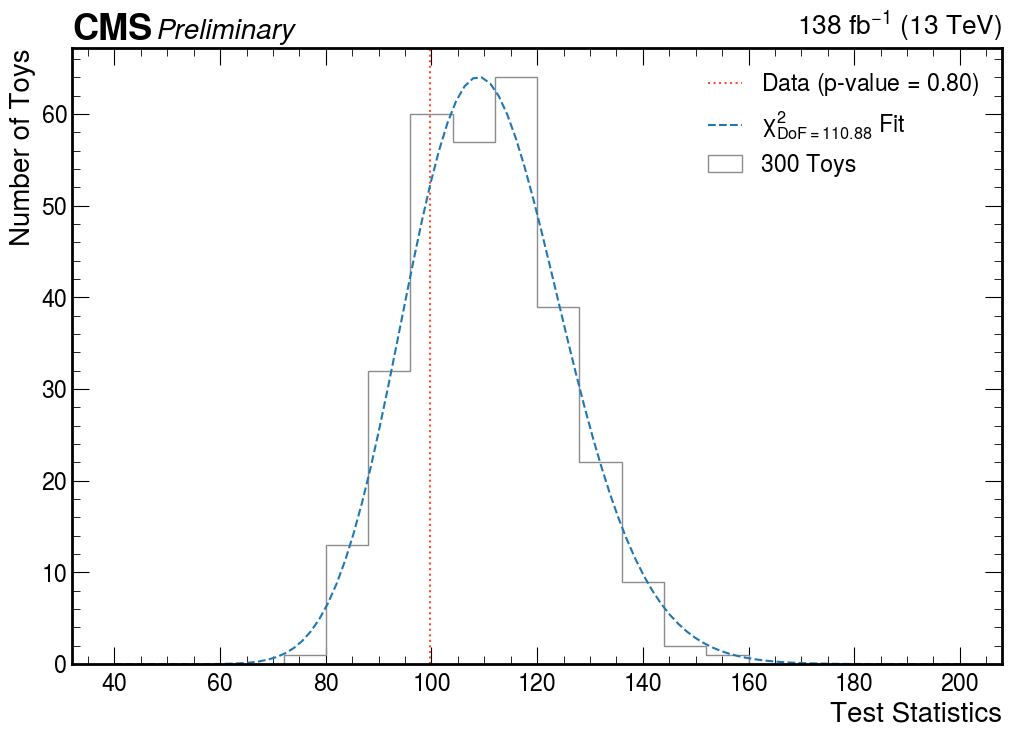

In [9]:
plot_tests(data_ts, toys_ts, "gof", fit="chi2", bins=20)